# Deep Semi-supervised Classification

In [1]:
from src.skeleton import BaseModel

### 샘플 데이터셋 생성

In [2]:
from src.utils.data_utils import TwoMoonDataset
import torch

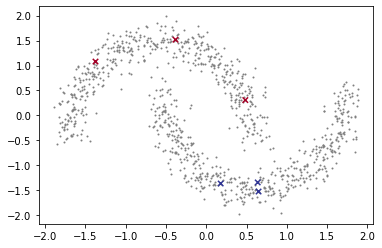

In [3]:
import matplotlib.pyplot as plt
P=0.003
train_dataset = TwoMoonDataset(1000, noise=(0.1,0.1), n_label=int(1000*P))
test_dataset = TwoMoonDataset(1000, noise=(0.1,0.1), n_label=1000)
X = train_dataset.X
y = train_dataset.y
M = train_dataset.M

plt.scatter(X[:,0], X[:,1], c='gray', s=1)
plt.scatter(X[M][:,0], X[M][:,1], c=y[M], s=30, marker='x', cmap='RdYlBu')
plt.show()

In [4]:
print(len(train_dataset), len(test_dataset))

1000 1000


### 주어진 label만 활용한 supervised learning 결과 확인 (A1과 동일한 모델)

In [5]:
import torch.nn as nn
class MyModel_supervised(BaseModel):
    def __init__(self, in_dim, out_dim, model_name='my_model_sup'):
        super().__init__(model_name=model_name)
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, batch, label=None, mask=None):
        x = self.fc1(batch)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        if mask.sum() == 0:
            return None
        return nn.CrossEntropyLoss()(pred[mask], label[mask])
    def compute_score(self, pred=None, batch=None, label=None, mask=None):
        #print('compute_score input : ', pred.shape)
        pred_cls = torch.argmax(pred, dim=1)
        correct = (pred_cls[mask]==label[mask]).sum()
        return correct / (label[mask].shape[0]+1e-10)

In [6]:
BATCH = 1000
EPOCH = 500
LR = 1e-2

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH)
test_loader = DataLoader(test_dataset, batch_size=BATCH)

In [8]:
model = MyModel_supervised(2,2)
model.cuda()

MyModel_supervised(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)

In [9]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR)

In [10]:
model.train_model(train_loader, test_loader, EPOCH, optimizer, report_intv=50)

(0.28s) [Epoch 1]
	Train Loss : 6.8551e-01	Train Score : 5.0000e-01
	Eval Loss : 3.0897e-01	Eval Score : 8.8300e-01
(0.01s) [Epoch 51]
	Train Loss : 0.0000e+00	Train Score : 1.0000e+00
	Eval Loss : 3.1761e+00	Eval Score : 8.2000e-01
(0.01s) [Epoch 101]
	Train Loss : 0.0000e+00	Train Score : 1.0000e+00
	Eval Loss : 3.2211e+00	Eval Score : 8.2100e-01
(0.01s) [Epoch 151]
	Train Loss : 0.0000e+00	Train Score : 1.0000e+00
	Eval Loss : 3.2214e+00	Eval Score : 8.2100e-01
(0.01s) [Epoch 201]
	Train Loss : 0.0000e+00	Train Score : 1.0000e+00
	Eval Loss : 3.2214e+00	Eval Score : 8.2100e-01
(0.01s) [Epoch 251]
	Train Loss : 0.0000e+00	Train Score : 1.0000e+00
	Eval Loss : 3.2214e+00	Eval Score : 8.2100e-01
(0.01s) [Epoch 301]
	Train Loss : 0.0000e+00	Train Score : 1.0000e+00
	Eval Loss : 3.2214e+00	Eval Score : 8.2100e-01
(0.01s) [Epoch 351]
	Train Loss : 0.0000e+00	Train Score : 1.0000e+00
	Eval Loss : 3.2214e+00	Eval Score : 8.2100e-01
(0.01s) [Epoch 401]
	Train Loss : 0.0000e+00	Train Score : 

[Epoch 1]


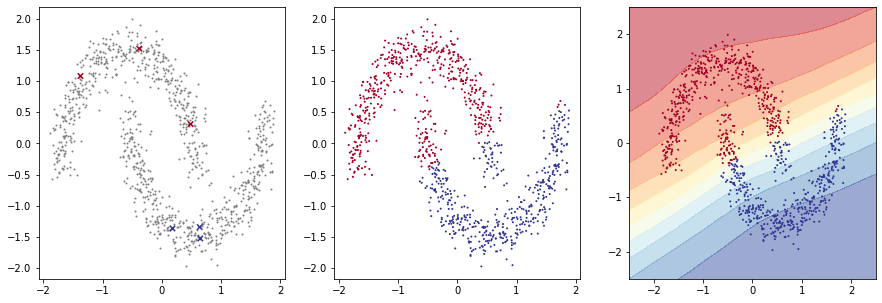

[Epoch 51]


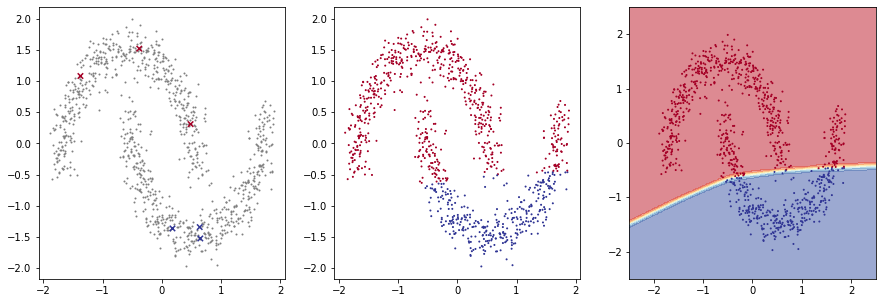

[Epoch 101]


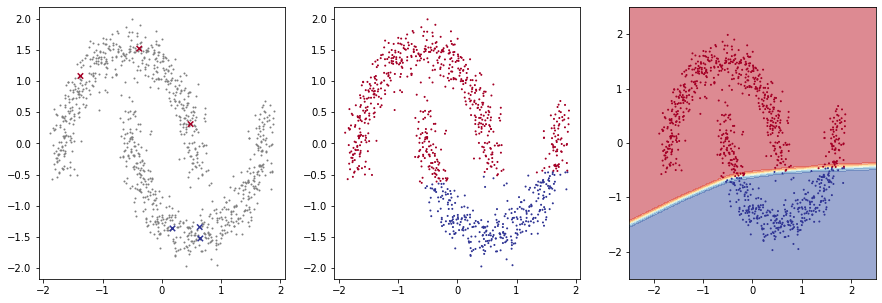

[Epoch 151]


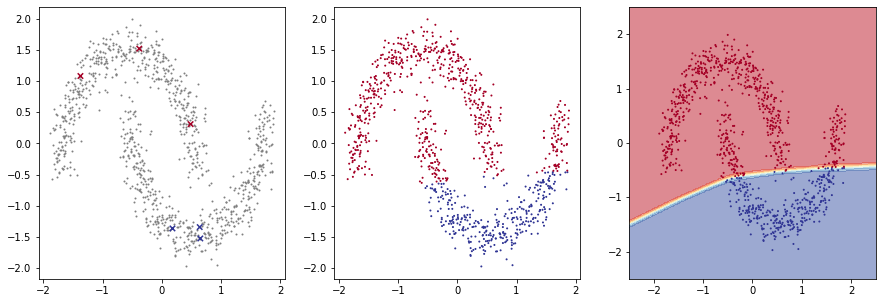

[Epoch 201]


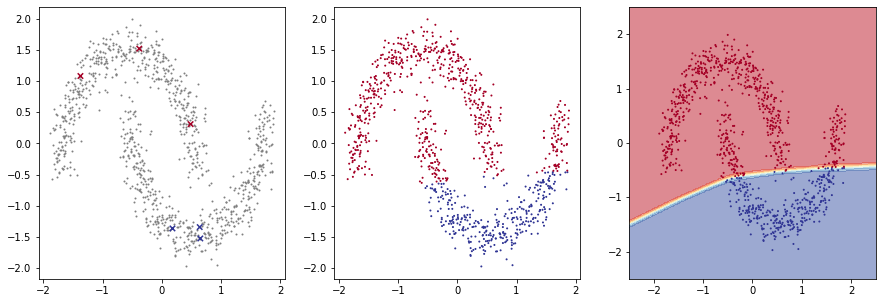

[Epoch 251]


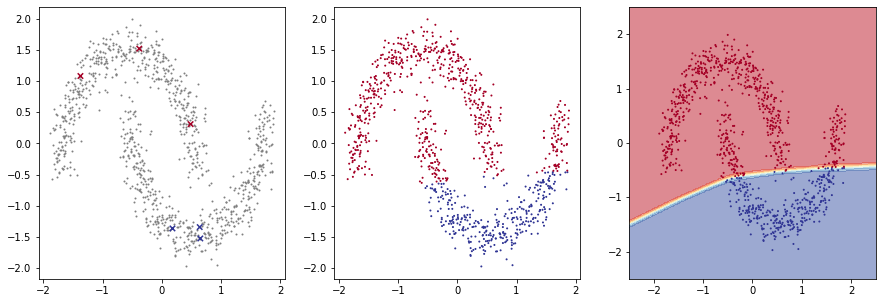

[Epoch 301]


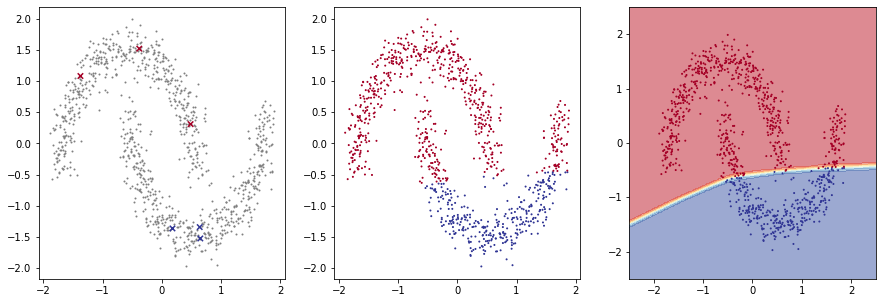

[Epoch 351]


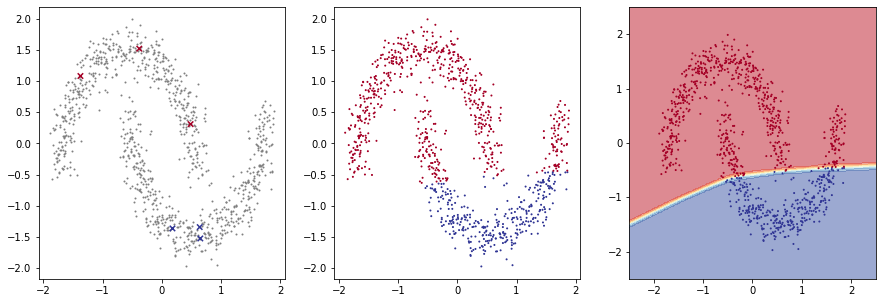

[Epoch 401]


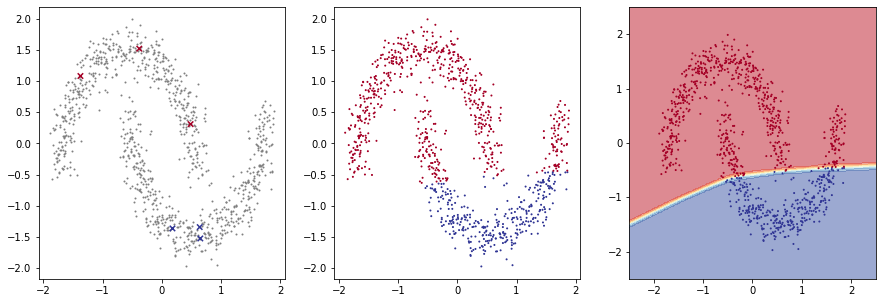

[Epoch 451]


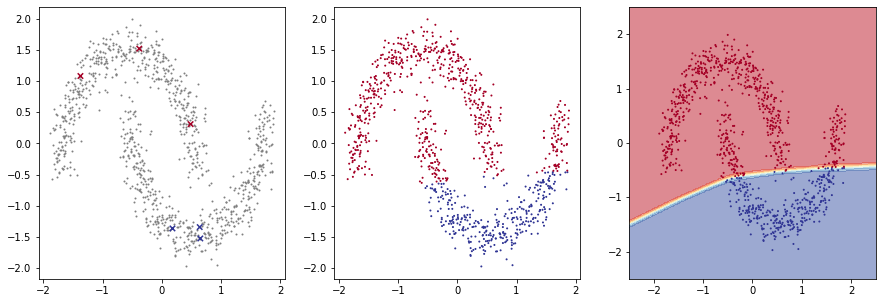

In [11]:
import numpy as np

a=np.linspace(-2.5,2.5,100)
x_grid,y_grid = np.meshgrid(a,a)
x_grid=x_grid.reshape(-1)
y_grid=y_grid.reshape(-1)

train_loader_noshuffle = DataLoader(train_dataset, shuffle=False, batch_size=BATCH)
grid_dataloader = DataLoader([(torch.tensor([x_grid[i],y_grid[i]]),0,True) for i in range(x_grid.shape[0])], batch_size=BATCH)


for e in range(0,500,50):
    model = MyModel_supervised(2,2)
    model.load_state_dict(torch.load('./saved_models/my_model_sup_e%d.pth'%(e+1)))
    print('[Epoch %d]'%(e+1))
    model.cuda()
    with torch.no_grad():
        pred=model.predict(train_loader_noshuffle)
        pred_grid=model.predict(grid_dataloader,soft_pred=True)

    X = train_dataset.X
    y = train_dataset.y
    M = train_dataset.M

    fig=plt.figure(figsize=(15,5))
    ax0 = plt.subplot(131)
    ax0.scatter(X[:,0],X[:,1],c='gray',s=1)
    ax0.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')

    ax1 = plt.subplot(132)
    ax1.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')

    ax2 = plt.subplot(133)
    ax2.contourf(x_grid.reshape(100,100), y_grid.reshape(100,100), pred_grid[:,1].reshape(100,100),cmap='RdYlBu',levels=np.linspace(0.0,1.0,11),alpha=0.5)
    ax2.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')
    plt.show()


## !!! Deep Semi-supervised Classification 모델 생성
- ```__init__()``` method에서 모델의 layer 정의
    - !!! + **beta** 정의
- !!! ```preprocess()``` method에서 **perturbed 데이터** 생성
    - output : batch와 perturbed batch의 tuple
- ```forward()``` method에서 모델의 forward pass 정의
    - !!! input batch : ```preprocess()``` method의 output과 동일한 **tuple**
    - !!! output 형태 : (batch, n_class) 형태 tensor의 **tuple**
- ```criterion()``` method에서 모델의 loss 함수 정의
    - !!! input pred : ```forward()``` method의 output과 동일한 **tuple**
- ```compute_score()``` method에서 예측 accuracy 측정
    - !!! input pred : ```forward()``` method의 output과 동일한 **tuple**
    
#### !!! **perturbation 함수** 정의

In [12]:
import torch.nn as nn
import torch.nn.functional as F

def CrossEntropy(q,p):
    b = F.softmax(p, dim=1) * F.log_softmax(q, dim=1)
    b = -1.0*b.mean()
    return b

def perturb(data, sig=0.15):
    eps = torch.randn(data.size()).to(device=data.device)
    return data+eps*sig

class MyModel_ssl(BaseModel):
    def __init__(self, in_dim, out_dim, model_name='my_model_ssl', beta=1.0):
        super().__init__(model_name=model_name)
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, out_dim)
        self.relu = nn.ReLU()
        self.beta = beta
        
    def preprocess(self, batch=None, label=None, mask=None):
        batch_perturb = perturb(batch)
        if self.training:
            batch = perturb(batch)
        return batch, batch_perturb
    
    def forward(self, batch, label=None, mask=None):
        batch_original, batch_perturb = batch
        
        x = self.fc1(batch_original)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        with torch.no_grad():
            x2 = self.fc1(batch_perturb)
            x2 = self.relu(x2)
            x2 = self.fc2(x2)
            x2 = self.relu(x2)
            x2 = self.fc3(x2)
        
        return x, x2
    
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        pred_original, pred_perturb = pred
        loss_crossentropy = nn.CrossEntropyLoss()(pred_original[mask], label[mask])
        if mask.sum() == 0:
            loss_crossentropy = 0
        loss_distance = CrossEntropy(pred_original, pred_perturb)
        loss = loss_crossentropy + self.beta*loss_distance
        return loss
    def compute_score(self, pred=None, batch=None, label=None, mask=None):
        #print('compute_score input : ', pred.shape)
        pred_original, pred_perturb = pred
        pred_cls = torch.argmax(pred_original, dim=1)
        correct = (pred_cls[mask]==label[mask]).sum()
        return correct / (label[mask].shape[0]+1e-10)

모델 생성 및 CUDA로 이동

In [13]:
model = MyModel_ssl(2,2)
model.cuda()

MyModel_ssl(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)

optimizer 생성

In [14]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR)

#### ```train_model()``` method를 통해 모델 학습

In [15]:
model.train_model(train_loader, test_loader, EPOCH, optimizer, report_intv=50)

(0.02s) [Epoch 1]
	Train Loss : 1.0591e+00	Train Score : 3.3333e-01
	Eval Loss : 5.3854e-01	Eval Score : 8.8500e-01
(0.01s) [Epoch 51]
	Train Loss : 2.3535e-01	Train Score : 1.0000e+00
	Eval Loss : 3.5811e+00	Eval Score : 8.8400e-01
(0.01s) [Epoch 101]
	Train Loss : 1.2224e-01	Train Score : 1.0000e+00
	Eval Loss : 9.8006e+00	Eval Score : 7.2400e-01
(0.01s) [Epoch 151]
	Train Loss : 2.2015e-01	Train Score : 1.0000e+00
	Eval Loss : 1.9881e+00	Eval Score : 9.0700e-01
(0.01s) [Epoch 201]
	Train Loss : 1.3346e-01	Train Score : 1.0000e+00
	Eval Loss : 1.6695e+00	Eval Score : 9.3600e-01
(0.01s) [Epoch 251]
	Train Loss : 1.8287e-01	Train Score : 1.0000e+00
	Eval Loss : 2.3394e+00	Eval Score : 9.2900e-01
(0.01s) [Epoch 301]
	Train Loss : 5.2245e-01	Train Score : 1.0000e+00
	Eval Loss : 1.1368e+01	Eval Score : 8.7500e-01
(0.01s) [Epoch 351]
	Train Loss : 3.8985e-01	Train Score : 1.0000e+00
	Eval Loss : 7.7322e+00	Eval Score : 9.0400e-01
(0.01s) [Epoch 401]
	Train Loss : 5.1861e-01	Train Score : 

# 결과 분석

[Epoch 1]


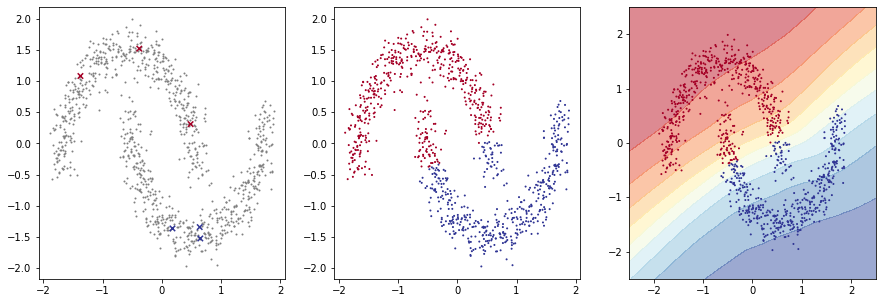

[Epoch 51]


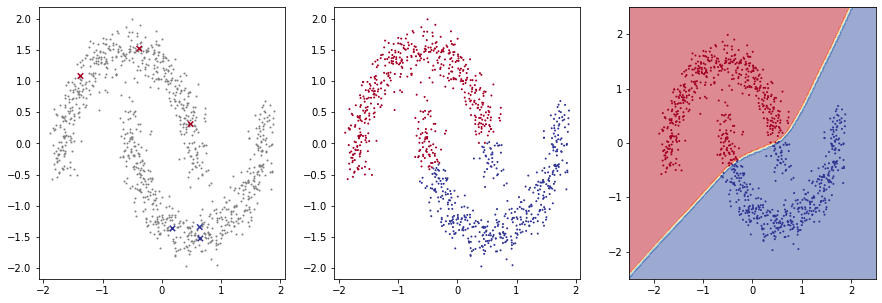

[Epoch 101]


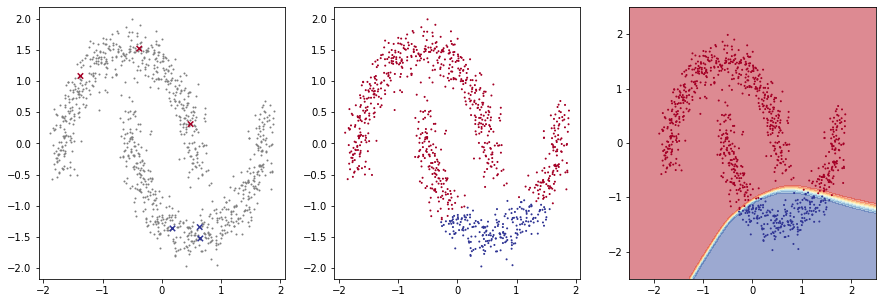

[Epoch 151]


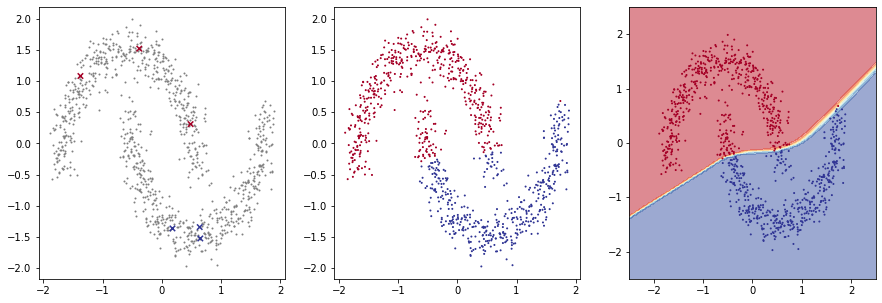

[Epoch 201]


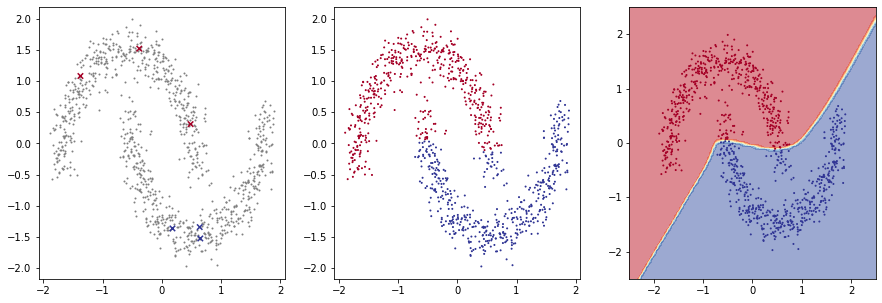

[Epoch 251]


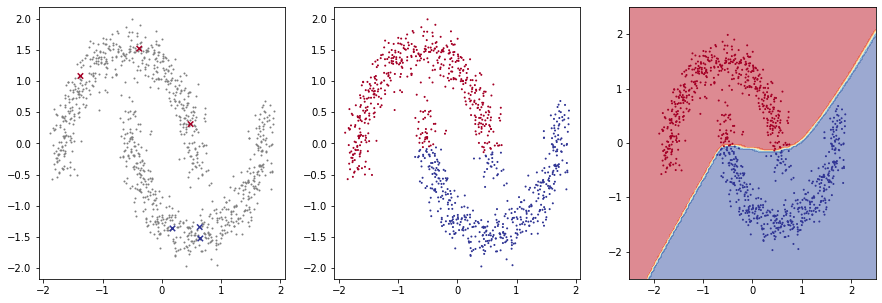

[Epoch 301]


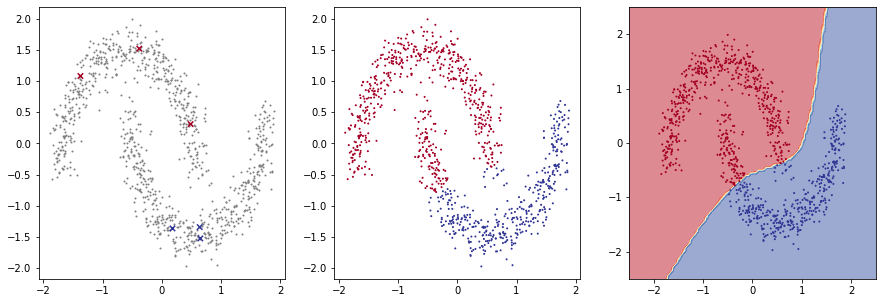

[Epoch 351]


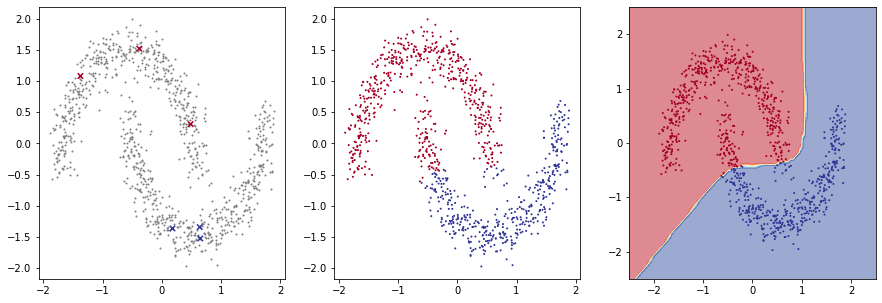

[Epoch 401]


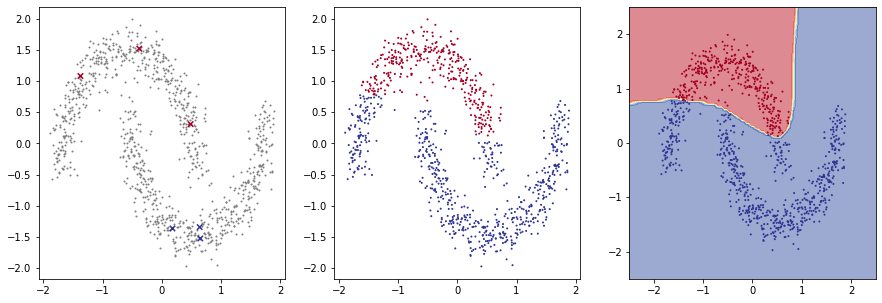

[Epoch 451]


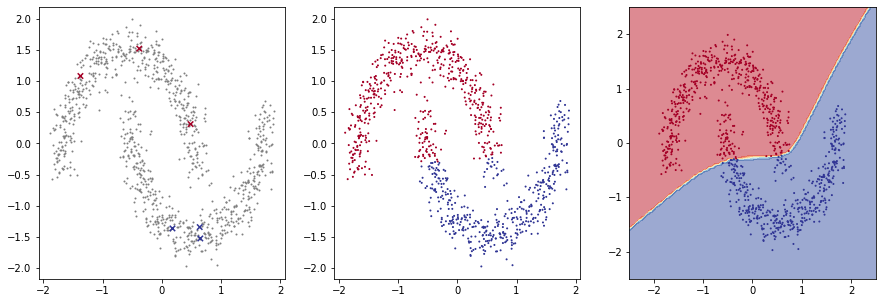

In [16]:
import numpy as np

a=np.linspace(-2.5,2.5,100)
x_grid,y_grid = np.meshgrid(a,a)
x_grid=x_grid.reshape(-1)
y_grid=y_grid.reshape(-1)

train_loader_noshuffle = DataLoader(train_dataset, shuffle=False, batch_size=BATCH)
grid_dataloader = DataLoader([(torch.tensor([x_grid[i],y_grid[i]]),0,True) for i in range(x_grid.shape[0])], batch_size=BATCH)


for e in range(0,500,50):
    model = MyModel_ssl(2,2)
    model.load_state_dict(torch.load('./saved_models/my_model_ssl_e%d.pth'%(e+1)))
    print('[Epoch %d]'%(e+1))
    model.cuda()
    
    with torch.no_grad():
        pred=model.predict(train_loader_noshuffle)
        pred_grid=model.predict(grid_dataloader,soft_pred=True)

    X = train_dataset.X
    y = train_dataset.y
    M = train_dataset.M

    fig=plt.figure(figsize=(15,5))
    ax0 = plt.subplot(131)
    ax0.scatter(X[:,0],X[:,1],c='gray',s=1)
    ax0.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')

    ax1 = plt.subplot(132)
    ax1.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')

    ax2 = plt.subplot(133)
    ax2.contourf(x_grid.reshape(100,100), y_grid.reshape(100,100), pred_grid[:,1].reshape(100,100),cmap='RdYlBu',levels=np.linspace(0.0,1.0,11),alpha=0.5)
    ax2.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')
    plt.show()
